In [2]:
#! pip install implicit

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Матричная факторизация
from implicit.als import AlternatingLeastSquares

# Работа с матрицами
from scipy.sparse import csr_matrix

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# Матричная факторизация

# Работа с матрицами


## CONSTANT

In [2]:
FILENAME = "df_condition.csv"

min_num_of_records = 5
min_trackable_name_count = 50
min_num_of_dates = 2

NUM_TOP_K = 1000

## Functions

In [358]:
class TimeDf:
    # загрузка файла
    def load_csv(filename):
        # file_loc = 'files/'+filename+'.csv'
        file_loc = filename
        data = pd.read_csv(file_loc, low_memory=False)
        return data

    # расчет таблицы count по колонке
    def calculate_count_table(df, column_name):
        counts = df[column_name].value_counts().reset_index()
        counts.columns = [column_name, "count"]

        counts = counts.sort_values(by="count")
        return counts

    # удаление колонок
    def drop_columns(df, columns):
        if [col for col in columns if col in df.columns]:
            df = df.drop(columns=columns)
        return df

    # Выбираем записи, где количество встречаемости trackable_name > min_count
    def del_rows_where_count_more_than_value(
        df, df_count, min_count, col="trackable_name"
    ):
        merged_df = df.merge(df_count, on=col, how="inner")
        merged_df = merged_df.drop(merged_df.columns[0], axis=1)
        df_clean = merged_df[merged_df["count"] >= min_count]
        return df_clean

    # Выбираем записи где count_of_records > min_num_of_records
    # return df["user_id", "count_of_records"] where count_of_records > min_num_of_records
    def filter_count_of_records_by_user(df, num_of_records, by="user_id"):
        user_counts = df.groupby(by).size()
        user_counts.name = "count_of_records"
        users_records = user_counts[user_counts >= num_of_records]
        return pd.DataFrame(users_records).reset_index()

    # Выбираем записи где user_dates_count > min_num_of_dates
    def filter_user_by_number_of_dates(df, min_num_of_dates):
        user_dates_count = df.groupby("user_id")["checkin_date"].nunique()
        valid_users = user_dates_count[user_dates_count >= min_num_of_dates].index
        filtered_df = df[df["user_id"].isin(valid_users)]
        return filtered_df

    # mapping matrix - индексы переводятся в обычные и создается матрица соответствия
    def create_mappind_matrix(df, column):
        unique_user_ids = df[column].unique()
        numeric_user_ids = list(range(len(unique_user_ids)))
        mapping_dict = dict(zip(unique_user_ids, numeric_user_ids))

        name_new_column = "numeric_" + column
        df[name_new_column] = df[column].map(mapping_dict)

        mapping_matrix = pd.DataFrame(
            {column: unique_user_ids, name_new_column: numeric_user_ids}
        )

        return mapping_matrix, df


## ДОП ФУНКЦИИ
# Рассматриваем количество всех записей всех пользователей в день, строим график
def filter_data_plot(df, date1, date2):
    df["checkin_date"] = pd.to_datetime(df["checkin_date"])
    plt.figure(figsize=(6, 3))

    # Фильтрация данных по диапазону дат
    start_date = date1
    end_date = date2
    filtered_data = df[
        (df["checkin_date"] >= start_date) & (df["checkin_date"] <= end_date)
    ]

    filtered_data.plot(
        x="checkin_date", y="count", kind="line", color="black", ax=plt.gca()
    )

    plt.title("Распределение дат между {} и {}".format(start_date, end_date))
    plt.xlabel("Дата")
    plt.ylabel("Количество событий")
    plt.xticks(rotation=45)
    plt.show()


# df_count_date = calculate_count_table(df_clean,"checkin_date")
# filter_data_plot(df_count_date, '2015-01-01', '2019-01-01')


# testing - существование юзеров - тест плохо написан, можно удалить/переделать
def some_test(df_clean):
    test_id1 = "QEVuQwEA++z6GMJgxyjYYw0jFdXeDw=="  # user with a lot of rows
    test_id2 = "QEVuQwEAUGIfNYeSSYSHAiACdW4/EA=="  # user with a 1 row
    test_id3 = "QEVuQwEAmoJdC6S79c4qmNNWxXJtFA=="  # user with a 2 row
    test_id4 = "QEVuQwEAsBPVHou+Hpfq1GeehpjG6Q=="  # user NaN
    test_id5 = "QEVuQwEAO18wayHaoaXcyWjKktyzYA=="  # usual user

    test_ids = [test_id1, test_id5, test_id4]

    def check_user_existance(df, user_id):
        if user_id in df["user_id"].values:
            print(f"Строка с user_id {user_id} существует.")
        else:
            print(f"Строка с user_id {user_id} не существует.")

    check_user_existance(df_clean, test_id1)
    check_user_existance(df_clean, test_id2)
    check_user_existance(df_clean, test_id3)

    pass


# тест на конкатенацию train и test части по user
def test_user_concatenation(df_clean, test_df, train_df, test_id):
    def df_id(df, test_id):
        return df.loc[df["user_id"] == test_id]

    user = df_id(df_clean, test_id)
    user_test = df_id(test_df, test_id)
    user_train = df_id(train_df, test_id)

    concatenated_user = pd.concat([user_train, user_test]).sort_index()
    assert (
        user.sort_index().equals(concatenated_user) and len(user) > min_num_of_records
    ), "user != user_train + user_test"

In [5]:
proc = TimeSeriesDataProcessor()
df = proc.load_csv(filename=FILENAME)

In [6]:
df

,Unnamed: 0,user_id,age,sex,country,checkin_date,trackable_id,trackable_type,trackable_name,trackable_value
0,0,QEVuQwEABlEzkh7fsBBjEe26RyIVcg==,NaN,NaN,NaN,2015-11-26,1069,Condition,ulcerative colitis,0
1,1,QEVuQwEAWRNGnuTRqXG2996KSkTIEw==,32.0,male,US,2015-11-26,1069,Condition,ulcerative colitis,0
2,2,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3168,Condition,pain left upper arm felt like getting shot,4
3,3,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3169,Condition,hip pain gettin,3
4,4,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3170,Condition,pain hand joints,4
...,...,...,...,...,...,...,...,...,...,...
1111512,7976184,QEVuQwEA/3ZnJPHdtLiOWBy1VAYIYA==,48.0,male,GB,2019-12-04,7,Condition,achalasia,3
1111513,7976206,QEVuQwEAtlfm8VyoxZ9biWjDHb74gQ==,22.0,female,GB,2019-12-04,2075,Condition,period pain,1
1111514,7976207,QEVuQwEAtlfm8VyoxZ9biWjDHb74gQ==,22.0,female,GB,2019-12-04,64,Condition,anxiety,3
1111515,7976208,QEVuQwEAtlfm8VyoxZ9biWjDHb74gQ==,22.0,female,GB,2019-12-04,291,Condition,depression,2


In [359]:
# TOP_K
# Создание экземпляра класса
my_instance = TimeSeriesDataProcessor()

# Вызов статического метода function_one
result_one = MyDataProcessor.function_one()
print(result_one)  # Вывод: 1


# выбираем топ по количеству встречаемости
def top_table_by_count(df, top_k):
    popularity = calculate_counttable_by_columnname(df, "trackable_name")
    top = popularity.sort_values("count", ascending=False).head(top_k)
    return top


# выбираем топ по сумме значений
def top_table_by_value(df, top_k, value_name):
    popularity = df.groupby("trackable_name")[value_name].sum().reset_index()
    popularity.rename(columns={value_name: "sum_value"}, inplace=True)
    top = popularity.sort_values("sum_value", ascending=False).head(top_k)
    return top


# выбираем взвешенный топ -> на выходе merged_df, без top значений
def top_table_by_weight(df, top_k, value_name):
    count = calculate_count_table(df, "trackable_name")
    sum_value = df.groupby("trackable_name")[value_name].sum().reset_index()
    merged_df = sum_value.merge(count, on="trackable_name")

    merged_df["weighted_value"] = merged_df[value_name] / merged_df["count"]
    merged_df.rename(columns={value_name: "sum_value"}, inplace=True)
    return merged_df


# usage
# top_k_value = top_table_by_value(train_df, NUM_TOP_K, 'trackable_value')
# ddf = top_table_by_weight(train_df, NUM_TOP_K, 'trackable_value')
# ddf.sort_values('sum_value', ascending=False)

In [360]:
def find_row_by_user(dff, user):
    return dff[(dff["user_id"] == user)]


def find_row_by_user_and_condition(dff, user, cond):
    return dff[(dff["user_id"] == user) & (dff["trackable_name"] == cond)]


def find_rows_by_column_value(df, col, value):
    return df[(df[col] == value)]

In [361]:
# плотность матрицы
def matrix_density(df):
    return df.sum().sum() / (df.shape[0] * df.shape[1]) * 100


# test user_item_matrix - плохой тест
def test_for_user_item_matrix(user_item_matrix, df):
    test_user = "QEVuQwEAzp6KBKQCpD5GYbu8CLlPiQ=="
    test_condition = "wrist pain"

    print(
        "Количество записей в разреженой матрице:",
        user_item_matrix.loc[test_user].loc[test_condition],
    )
    return find_row_by_user_and_condition(df, test_user, test_condition)

In [362]:
# preparation to als
def some_ids_preparation_to_als(user_item_matrix):
    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))

    return itemid_to_id, userid_to_id, id_to_itemid, id_to_userid


# itemid_to_id, userid_to_id, id_to_itemid, id_to_userid = some_ids_preparation_to_als(user_item_matrix)

## Data preparation

In [363]:
# Загружаем подготовленный файл filename
raw_data = load_csv(FILENAME)

In [364]:
df = raw_data.copy()

# Подсчитываем количество встречаемости trackable_name
df_count_trackable_name = calculate_count_table(df, "trackable_name").sort_values(
    by="count", ascending=False
)
# Выбираем записи, где количество встречаемости trackable_name > min_trackable_name_count
df_clean = del_rows_where_count_more_than_value(
    df=df,
    df_count=df_count_trackable_name,
    min_count=min_trackable_name_count,
    col="trackable_name",
)
# Удаляем ненужные колонки
df_clean = drop_columns(df_clean, ["count", "trackable_type"])
# Подсчитываем количество записей на каждого юзера и фильтруем count_of_records >= min_num_of_records
filtered_users_with_counts = filter_count_of_records_by_user(
    df_clean, min_num_of_records
)
# Оставляем в df_clean только отфильтрованные user_id
df_clean = df_clean[df_clean["user_id"].isin(filtered_users_with_counts["user_id"])]
# Фильтруем, что у пользователя количество дат записей >= min_num_of_dates
df_clean = filter_user_by_number_of_dates(df_clean, min_num_of_dates)

# добавляем числовые индексы для 'user_id' и 'trackable_name'
mapping_matrix_id, df_clean = create_mappind_matrix(df_clean, "user_id")
mapping_matrix_trackable, df_clean = create_mappind_matrix(df_clean, "trackable_name")

In [365]:
df_clean.sort_values(by="checkin_date").head(5)

,user_id,age,sex,country,checkin_date,trackable_id,trackable_name,trackable_value,numeric_user_id,numeric_trackable_name
484924,QEVuQwEAAB+8lfnyyyCt9KnUL1t6Vw==,36.0,female,CA,2015-05-24,80,asthma,0,5267,75
868116,QEVuQwEAAB+8lfnyyyCt9KnUL1t6Vw==,36.0,female,CA,2015-05-24,1260,bruxism,0,5267,546
162955,QEVuQwEAJUffVHQmvKSzatPkDcmNvQ==,26.0,female,CA,2015-05-24,397,fibromyalgia,4,419,19
159115,QEVuQwEAAB+8lfnyyyCt9KnUL1t6Vw==,36.0,female,CA,2015-05-24,397,fibromyalgia,4,5267,19
867979,QEVuQwEAJUffVHQmvKSzatPkDcmNvQ==,26.0,female,CA,2015-05-24,940,sickle cell anemia,3,419,545


## Create Train and Test

In [366]:
# df_clean необходимо разделить на train и test: test выбирает по последней дате записи пользователя
# то есть в train мы берем все до последней даты, а в test - последнюю дату

df_clean_sorted = df_clean.sort_values(by=["user_id", "checkin_date"])
grouped_df = df_clean_sorted.groupby("user_id")

train_data = []
test_data = []

for user_id, group_df in grouped_df:
    # Получаем последнюю дату для данного пользователя
    last_date = group_df["checkin_date"].max()
    # Выбираем все записи кроме последней даты для обучающего набора
    train_data.append(group_df[group_df["checkin_date"] != last_date])
    # Выбираем все записи на последнюю дату для тестового набора
    test_data.append(group_df[group_df["checkin_date"] == last_date])

train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

# тест на конкатенацию train и test части по user (обычный пользователь)
test_user_concatenation(df_clean, test_df, train_df, "QEVuQwEAO18wayHaoaXcyWjKktyzYA==")

## ALS

### Создание user_item_matrix

In [367]:
data = df_clean
data.columns = [col.lower() for col in data.columns]

train_df.head(3)

,user_id,age,sex,country,checkin_date,trackable_id,trackable_name,trackable_value,numeric_user_id,numeric_trackable_name
118644,QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==,30.0,female,BE,2019-09-19,649,migraine,0,6063,13
203334,QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==,30.0,female,BE,2019-09-19,397,fibromyalgia,3,6063,19
294358,QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==,30.0,female,BE,2019-09-19,886,rheumatoid arthritis,2,6063,39


In [368]:
# INFORMATION ABOUT TRAIN/TEST
def print_df_info(df):
    users, items, interactions = (
        df["user_id"].nunique(),
        df["trackable_name"].nunique(),
        df.shape[0],
    )
    info_str = (
        "# users: "
        + str(users)
        + " # items: "
        + str(items)
        + " # interactions: "
        + str(interactions)
    )
    return info_str


print("df:       ", print_df_info(df))
print("df_clean: ", print_df_info(df_clean))
print("train_df: ", print_df_info(train_df))
print("test_df:  ", print_df_info(test_df))

df:        # users: 38308 # items: 8981 # interactions: 1111517
df_clean:  # users: 14189 # items: 1544 # interactions: 995181
train_df:  # users: 14189 # items: 1544 # interactions: 933234
test_df:   # users: 14189 # items: 1489 # interactions: 61947


In [369]:
# create top_k list
top_k = top_table_by_count(train_df, NUM_TOP_K)
top_k_list = top_k.trackable_name.tolist()

In [370]:
# замена редко встречающихся диагнозов на 999999
train_df.loc[~train_df["trackable_name"].isin(top_k_list), "trackable_name"] = 999999

# СОЗДАНИЕ user_item_matrix
user_item_matrix = pd.pivot_table(
    train_df,
    index="numeric_user_id",
    columns="trackable_name",
    values="trackable_value",
    aggfunc="count",
    fill_value=0,
)


user_item_matrix = user_item_matrix.astype(float)
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

trackable_name,999999,abdominal discomfort,abdominal migraines,abdominal pain,absentances,achalasia,aches,achilles tendinitis,achiness,achy,...,walking difficulty,warfair ok,water,weakness,web throat,weight loss,weird head eating,whiplash,wrist pain,yeast infection vaginal
numeric_user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [371]:
# INFORMATION ABOUT user_item_matrix
print("Размер user_item_matrix:", user_item_matrix.shape)
print("Плотность разреженой матрицы:", matrix_density(user_item_matrix))
# test_for_user_item_matrix()

Размер user_item_matrix: (14189, 1001)
Плотность разреженой матрицы: 6.570594815009502


### ALS

In [372]:
itemid_to_id, userid_to_id, id_to_itemid, id_to_userid = some_ids_preparation_to_als(
    user_item_matrix
)

In [373]:
userid = "numeric_user_id"
itemid = "trackable_name"
pd.set_option("display.max_colwidth", None)

result = test_df.groupby(userid)[itemid].unique().reset_index()
result.columns = [userid, "actual"]
result.head(4)

,numeric_user_id,actual
0,0,[ulcerative colitis]
1,1,"[depression, anxiety]"
2,2,"[ulcerative colitis, ehlersdanlos syndrome, addisons disease]"
3,3,"[ulcerative colitis, ehlersdanlos syndrome, addisons disease]"


In [467]:
%%time 


def building_model(factors):
    # Обучение модели
    model_als = AlternatingLeastSquares(
        factors=factors,  # скрытые факторы
        regularization=0.001,  # регуляризация, от переобучения модели
        iterations=30,
        calculate_training_loss=True,
        num_threads=4,
    )

    model_als.fit(csr_matrix(user_item_matrix).tocsr(), show_progress=True)
    return model_als


model_als = building_model(5)

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 2.15 s, sys: 38.5 ms, total: 2.18 s
Wall time: 1.17 s


#### Эмбеддинги items и users

In [454]:
# MODEL INFORMATION
print("item_factors:", model_als.item_factors.shape)
print("user_factors:", model_als.user_factors.shape)

# эмбеддинги items
item_factors = pd.DataFrame(model_als.item_factors)
# item_factors.head(3)

# эмбеддинги users
user_factors = pd.DataFrame(model_als.user_factors)
# user_factors.head(3)

item_factors: (1001, 50)
user_factors: (14189, 50)


#### UMAP

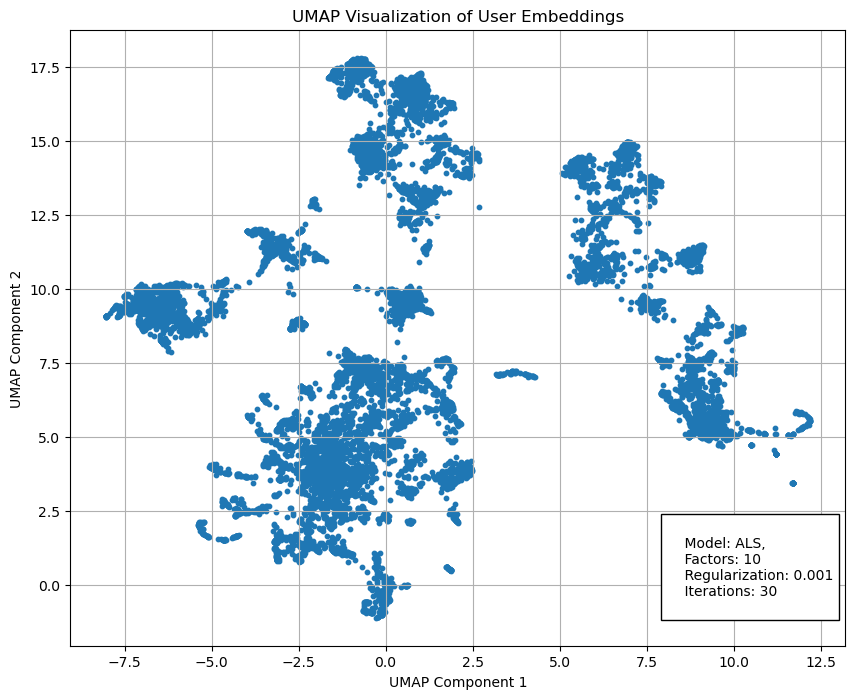

In [464]:
# pip install umap-learn
import umap

reducer = umap.UMAP(n_components=2)  # 2-мерный мир
umap_embeddings_users = reducer.fit_transform(user_factors)
umap_embeddings_items = reducer.fit_transform(item_factors)

# pd.DataFrame(umap_embeddings_users)
figure_umap_embeddings(
    umap_embeddings_users, name="UMAP Visualization of User Embeddings"
)

In [451]:
def figure_umap_embeddings(umap_emb, name):
    plt.figure(figsize=(10, 8))
    plt.scatter(umap_emb[:, 0], umap_emb[:, 1], s=10)  # Рассеиваем точки
    plt.title(name)  # Заголовок
    plt.xlabel("UMAP Component 1")  # Метка оси X
    plt.ylabel("UMAP Component 2")  # Метка оси Y
    plt.grid(True)  # Включаем сетку

    model_info = f"""
    Model: ALS, 
    Factors: {model_als.factors} 
    Regularization: {model_als.regularization}
    Iterations: {model_als.iterations}
    """

    # Добавление информации о модели в квадратике на графике
    if model_info:
        plt.text(
            0.77,
            0.05,
            model_info,
            ha="left",
            va="bottom",
            transform=plt.gca().transAxes,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=1),
        )

    # Определение save_path, чтобы избежать ошибки UnboundLocalError
    save_path = None

    if name == "UMAP Visualization of User Embeddings":
        name = f"ALS_f{model_als.factors}_r{model_als.regularization}_i{model_als.iterations}"
        save_path = f"UMAP_Users/{name}.png"

    # Сохранение графика в файл, если указан путь для сохранения
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

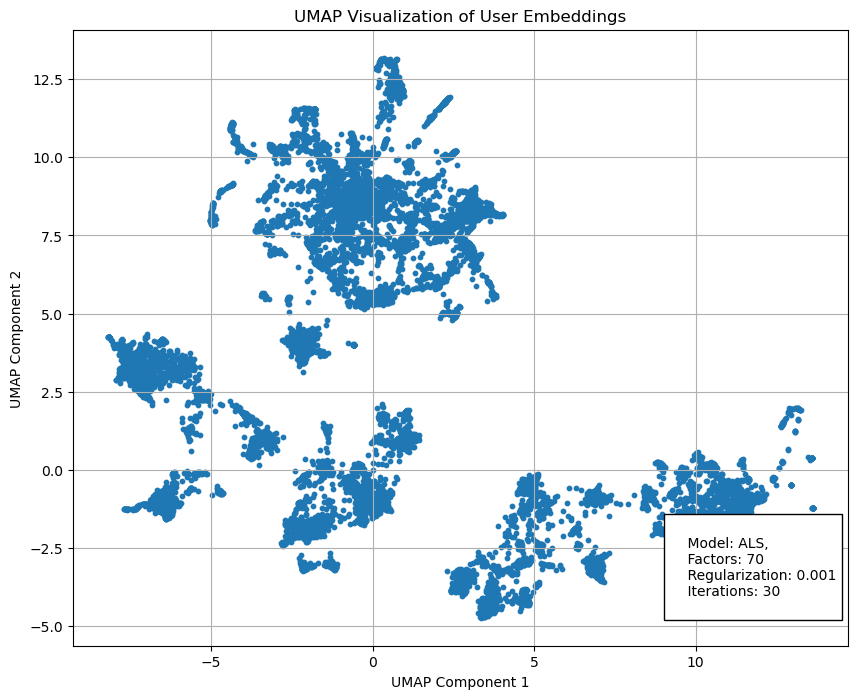

In [459]:
figure_umap_embeddings(
    umap_embeddings_users, name="UMAP Visualization of User Embeddings"
)

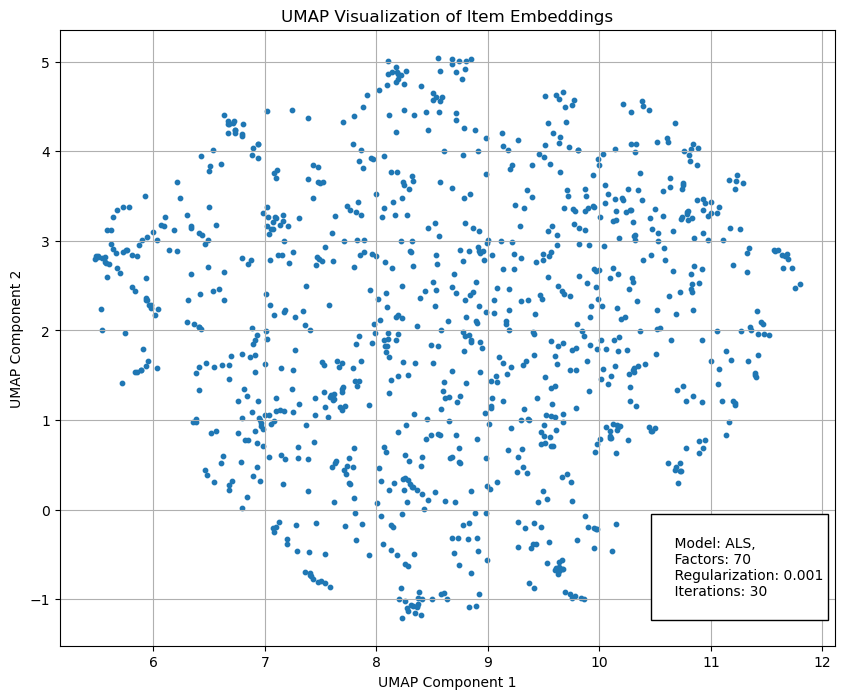

In [460]:
figure_umap_embeddings(
    umap_embeddings_items, name="UMAP Visualization of Item Embeddings"
)

### Other

In [381]:
TEST_USER = 301

In [382]:
recs = model_als.recommend(
    userid=userid_to_id[TEST_USER],
    user_items=csr_matrix(user_item_matrix.loc[userid_to_id[TEST_USER]]).tocsr(),
    N=2,
    recalculate_user=True,
)

recs

(array([863, 147], dtype=int32),
 array([0.01557896, 0.01144325], dtype=float32))

In [383]:
def find_row_by_user_and_col(dff, col, users):
    return dff[(dff[col].isin(users))]


# поиск похожих пользователей на тестового
df_users = find_row_by_user_and_col(result, col="numeric_user_id", users=recs[0])
df_users

,numeric_user_id,actual
147,147,"[ulcerative colitis, crohns disease, depression, chest pain, stomach pain, fatigue, anxiety, headaches, nausea, diarrhea, stomach cramps]"
863,863,"[gastroparesis, ehlersdanlos syndrome, postural orthostatic tachycardia syndrome pots]"


In [384]:
df_test_user = find_row_by_user_and_col(
    result, col="numeric_user_id", users=[TEST_USER]
)
df_test_user

,numeric_user_id,actual
301,301,"[headache, fatigue, narcolepsy, depressed mood, irritability]"


### TEST USER

In [385]:
TEST_USER = 301
find_rows_by_column_value(df=df_clean, col="numeric_user_id", value=TEST_USER)

,user_id,age,sex,country,checkin_date,trackable_id,trackable_name,trackable_value,numeric_user_id,numeric_trackable_name
6588,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-29,1356,headache,4,301,1
6589,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-30,1356,headache,4,301,1
319668,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-29,1164,fatigue,4,301,46
319669,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-30,1164,fatigue,4,301,46
426559,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-30,692,narcolepsy,4,301,59
565450,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-29,1167,depressed mood,4,301,107
565451,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-30,1167,depressed mood,2,301,107
710355,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-29,1254,irritability,4,301,250
710356,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-30,1254,irritability,2,301,250


In [386]:
find_rows_by_column_value(df=train_df, col="numeric_user_id", value=TEST_USER)

,user_id,age,sex,country,checkin_date,trackable_id,trackable_name,trackable_value,numeric_user_id,numeric_trackable_name
6588,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-29,1356,headache,4,301,1
319668,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-29,1164,fatigue,4,301,46
565450,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-29,1167,depressed mood,4,301,107
710355,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-29,1254,irritability,4,301,250


In [387]:
find_rows_by_column_value(df=test_df, col="numeric_user_id", value=TEST_USER)

,user_id,age,sex,country,checkin_date,trackable_id,trackable_name,trackable_value,numeric_user_id,numeric_trackable_name
6589,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-30,1356,headache,4,301,1
319669,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-30,1164,fatigue,4,301,46
426559,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-30,692,narcolepsy,4,301,59
565451,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-30,1167,depressed mood,2,301,107
710356,QEVuQwEAnUs61cL6FGHKXbI4omWKCQ==,17.0,female,US,2018-11-30,1254,irritability,2,301,250


In [388]:
# ------------
# def find_row_by_user_and_col(dff, col, users):
#     return dff[(dff[col].isin(users))]

# df_users = find_row_by_user_and_col(df_clean,col="numeric_user_id",users=recs[0])
# df_users


# ------------
def calculate_count_table_by(df, user_column, column_name):
    counts = df.groupby([user_column, column_name]).size()
    # .sort_values(by='count', ascending=False)
    # .reset_index(name='count')
    # counts = counts.sort_values(by='count', ascending=False)
    return counts


# result = calculate_count_table_by(df_users, 'numeric_user_id', 'trackable_name')
# result.columns = ['user_id','condition','count']
# pd.DataFrame(result)

### Other

In [389]:
similar_users = model_als.similar_items(TEST_USER, N=5)
similar_users

(array([301,  99, 462, 554, 228], dtype=int32),
 array([1.        , 0.8884903 , 0.8514504 , 0.8458477 , 0.82905513],
       dtype=float32))

In [390]:
# df_clean[df_clean['numeric_user_id']==similar_users[0][1]]
# df_clean[df_clean['numeric_user_id']==TEST_USER]
# df_clean[df_clean['numeric_user_id']==similar_users[0][2]]

## CREATE цикл по факторам

In [477]:
%%time 


def building_model(factors):
    # Обучение модели
    model_als = AlternatingLeastSquares(
        factors=factors,  # скрытые факторы
        regularization=0.001,  # регуляризация, от переобучения модели
        iterations=30,
        calculate_training_loss=True,
        num_threads=4,
    )

    model_als.fit(csr_matrix(user_item_matrix).tocsr(), show_progress=True)
    return model_als

CPU times: user 4 µs, sys: 7 µs, total: 11 µs
Wall time: 19.8 µs


In [481]:
# for factors in range(30, 60, 3):
#     model_als = building_model(factors)
#     user_factors = pd.DataFrame(model_als.user_factors)
#     umap_embeddings_users = umap.UMAP(n_components=2).fit_transform(user_factors)
#     figure_umap_embeddings(umap_embeddings_users, name='UMAP Visualization of User Embeddings')

## Clustering

  0%|          | 0/30 [00:00<?, ?it/s]

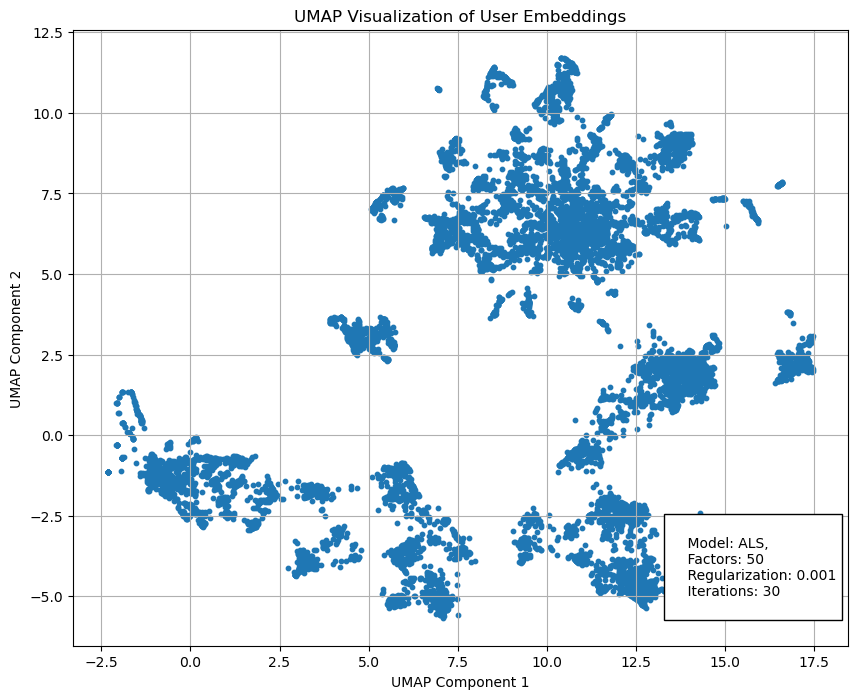

In [482]:
factors = 50
model_als = building_model(factors)
user_factors = pd.DataFrame(model_als.user_factors)
umap_embeddings_users = umap.UMAP(n_components=2).fit_transform(user_factors)
figure_umap_embeddings(
    umap_embeddings_users, name="UMAP Visualization of User Embeddings"
)

In [489]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [509]:
umap_emb = umap_embeddings_users
user_factors = pd.DataFrame(model_als.user_factors)
n_clusters = 6

### Определение оптимального количества кластеров

##### Elbow method

Text(0, 0.5, 'Within-cluster Sum of Squares')

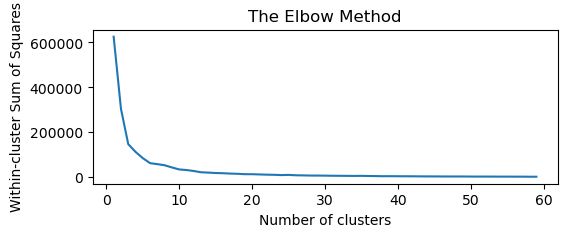

In [618]:
max_clusters = 60
wcss = []

for i in range(1, max_clusters):
    kmeans = KMeans(i, n_init="auto")
    kmeans.fit(umap_emb)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

plt.figure(figsize=(6, 2))
number_clusters = range(1, max_clusters)
plt.plot(number_clusters, wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Within-cluster Sum of Squares")

##### Коэффициент силуэта

In [619]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_clusters = 60


def figure_silhouette_score(max_clusters, umap_embedding, print=True):
    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
        cluster_labels = kmeans.fit_predict(umap_embedding)
        silhouette_avg = silhouette_score(umap_embedding, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    if print:
        plt.figure(figsize=(5, 2))
        number_clusters = range(2, max_clusters + 1)
        plt.plot(number_clusters, silhouette_scores, marker="o")
        plt.title("Silhouette Score")
        plt.xlabel("Number of Clusters")
        plt.ylabel("Silhouette Score")
        plt.show()

    return silhouette_scores

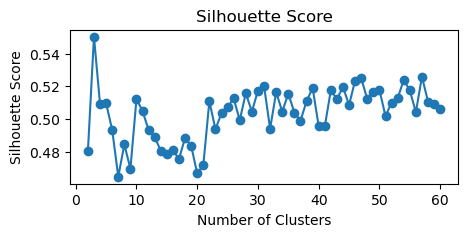

In [620]:
silhouette_scores = figure_silhouette_score(max_clusters, umap_emb, print=True)

##### BIC (Bayesian Information Criterion)

## cosine_similarity

In [760]:
# print clusters
def print_clusters(umap, cluster_labels, n_clusters):
    plt.figure(figsize=(15, 10))
    for cluster_id in range(n_clusters):
        cluster_points = umap[cluster_labels == cluster_id]
        plt.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            s=1,
            label=f"Cluster {cluster_id}",
        )
        # Добавляем метку кластера
        centroid_x = cluster_points[:, 0].mean()
        centroid_y = cluster_points[:, 1].mean()
        plt.text(
            centroid_x,
            centroid_y,
            str(cluster_id),
            fontsize=10,
            color="black",
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="square"),
        )

    plt.title("Clusters of UMAP User Embeddings")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    # plt.legend()
    plt.show()


# cosine average_similarity
def compute_cosine_similarity(cluster_embeddings):
    similarity_matrix = cosine_similarity(cluster_embeddings)
    average_similarity = similarity_matrix.mean()
    return average_similarity

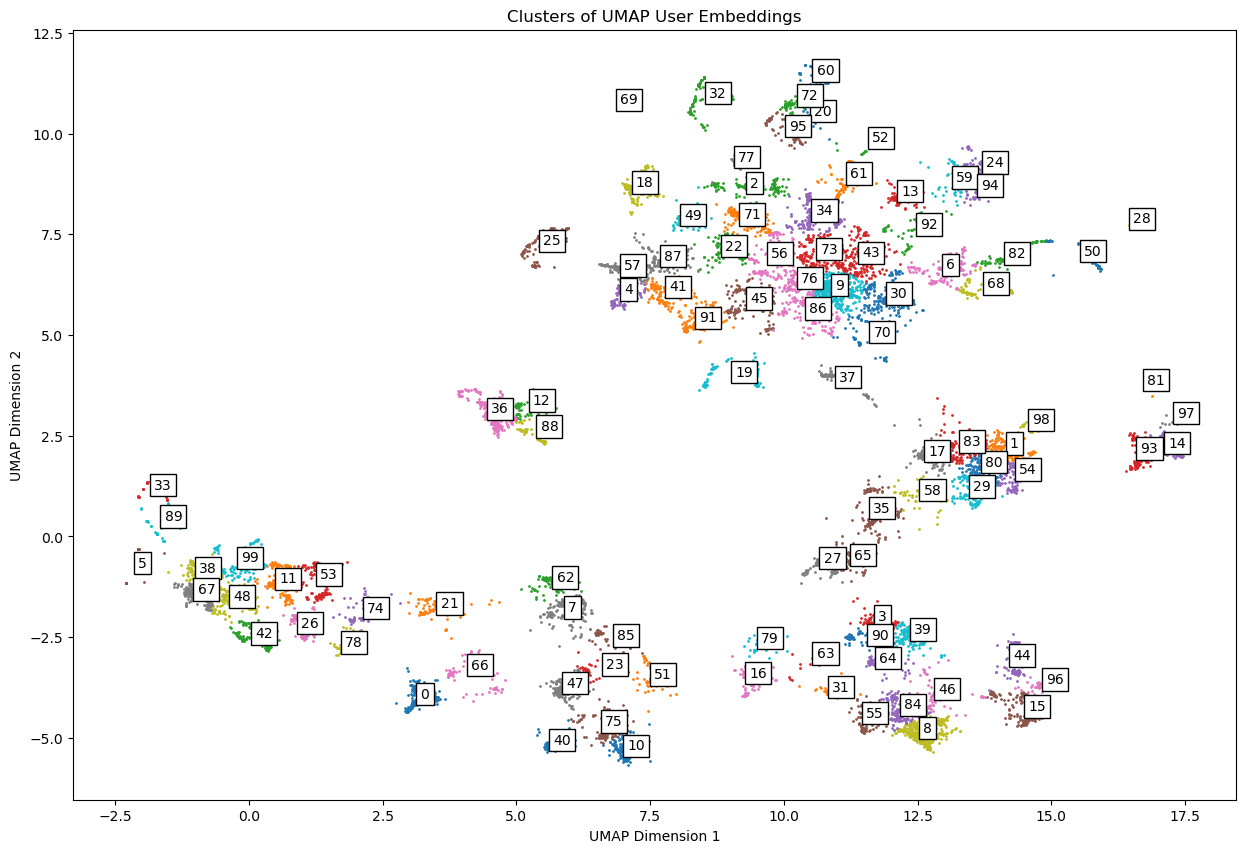

In [766]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

umap_emb = umap_embeddings_users
user_factors = pd.DataFrame(model_als.user_factors)
n_clusters = 100

kmeans = KMeans(n_clusters=n_clusters, random_state=100, n_init="auto")
cluster_labels = kmeans.fit_predict(umap_embeddings_users)

cos_sim = {}

for cluster_id in range(n_clusters):
    cluster_points = umap_emb[cluster_labels == cluster_id]
    cos_sim[cluster_id] = compute_cosine_similarity(cluster_points)

print_clusters(umap_embeddings_users, cluster_labels, n_clusters)

In [631]:
# cluster_labels - вектор кластеров соответствующий umap_embeddings_users
# pd.DataFrame(cluster_labels)
# pd.DataFrame(umap_embeddings_users)

In [755]:
cos_sim_df = pd.DataFrame(
    list(cos_sim.items()), columns=["Cluster #", "Cosine Similarity"]
)
# cos_sim_df

## SIMILARITY

In [767]:
count_trname_by_cluster = {}

assert (
    len(cluster_labels) == umap_emb.shape[0]
), "Dimensions mismatch: cluster_labels and umap_emb"
umap_emb_with_cluster_labels = np.hstack((umap_emb, cluster_labels.reshape(-1, 1)))

cluster_ids = drop_columns(pd.DataFrame(umap_emb_with_cluster_labels), [0, 1])
cluster_ids["numeric_user_id"] = cluster_ids.index
cluster_ids = cluster_ids.rename(columns={cluster_ids.columns[0]: "cluster_id"})
pd.DataFrame(cluster_ids)

,cluster_id,numeric_user_id
0,52.0,0
1,8.0,1
2,57.0,2
3,53.0,3
4,16.0,4
...,...,...
14184,86.0,14184
14185,98.0,14185
14186,86.0,14186
14187,98.0,14187


In [768]:
train_df_with_clusters = pd.merge(
    train_df, cluster_ids, on="numeric_user_id", how="inner"
)
train_df_with_clusters

,user_id,age,sex,country,checkin_date,trackable_id,trackable_name,trackable_value,numeric_user_id,numeric_trackable_name,cluster_id
0,QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==,30.0,female,BE,2019-09-19,649,migraine,0,6063,13,21.0
1,QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==,30.0,female,BE,2019-09-19,397,fibromyalgia,3,6063,19,21.0
2,QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==,30.0,female,BE,2019-09-19,886,rheumatoid arthritis,2,6063,39,21.0
3,QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==,30.0,female,BE,2019-09-19,1288,leaky gut,1,6063,160,21.0
4,QEVuQwEA++z6GMJgxyjYYw0jFdXeDw==,30.0,female,BE,2019-09-19,1022,thoracic outlet syndrome,2,6063,510,21.0
...,...,...,...,...,...,...,...,...,...,...,...
933229,QEVuQwEAzzjRwczxpcJbYi6PbLtkCw==,44.0,other,GB,2018-12-09,220,chronic fatigue syndrome,3,11646,53,36.0
933230,QEVuQwEAzzjRwczxpcJbYi6PbLtkCw==,44.0,other,GB,2018-12-10,220,chronic fatigue syndrome,3,11646,53,36.0
933231,QEVuQwEAzzjRwczxpcJbYi6PbLtkCw==,44.0,other,GB,2018-12-11,220,chronic fatigue syndrome,3,11646,53,36.0
933232,QEVuQwEAzzjRwczxpcJbYi6PbLtkCw==,44.0,other,GB,2018-12-12,220,chronic fatigue syndrome,3,11646,53,36.0


In [769]:
def find_rows_by_column_and_values(df, col, values):
    """
    Находит строки в DataFrame, где значение указанного столбца содержится в списке заданных значений.

    Параметры:
        df (DataFrame): DataFrame, в котором производится поиск.
        col (str): Название столбца, по которому осуществляется поиск.
        values (list): Список значений для поиска.

    Возвращает:
        DataFrame: DataFrame, содержащий строки, где значение указанного столбца содержится в списке значений.
    """
    return df[df[col].isin(values)]

In [770]:
cluster_name_id = n_clusters
users_by_cluster = find_rows_by_column_value(
    train_df_with_clusters, "cluster_id", cluster_name_id
)
# users_by_cluster
users = users_by_cluster.numeric_user_id.unique()
df_user_results = find_rows_by_column_and_values(result, "numeric_user_id", users)
df_user_results.head(2)

,numeric_user_id,actual


In [771]:
# создаем словарь count_trname_by_cluster[cluster_id] с данными расчетов чаще всего встречающихся заболеваний у группы людей
for cluster_name_id in range(0, n_clusters):
    users_by_cluster = find_rows_by_column_value(
        train_df_with_clusters, "cluster_id", cluster_name_id
    )
    # users_by_cluster
    users = users_by_cluster.numeric_user_id.unique()
    df_user_results = find_rows_by_column_and_values(result, "numeric_user_id", users)
    df_user_results.head(40)
    count_trname_by_cluster[cluster_name_id] = calculate_count_table(
        users_by_cluster, "trackable_name"
    ).sort_values(by="count", ascending=False)

In [780]:
count_trname_by_cluster[81].head(15)

,trackable_name,count
0,menieres disease,971
1,heart palpitations,160
2,migraine,160
3,anxiety,151
4,endometriosis,126
5,back pain,89
6,asthma,84
7,hypothyroidism,18
8,fibromyalgia,15
9,trigeminal neuralgia,15


In [763]:
count_trname_by_cluster[21].head(15)

,trackable_name,count
0,ibs,1650
1,endometriosis,316
2,fibromyalgie,315
3,hypoparathyroidism,225
4,migraine aura,188
5,gastroparesis,128
6,chronic migraines,100
7,stress,100
8,headaches,94
9,intestinal obstruction,90


In [775]:
# Объединяем таблицы по столбцу trackable_name и суммируем значения столбца count
merged_df = pd.merge(
    count_trname_by_cluster[2],
    count_trname_by_cluster[5],
    on="trackable_name",
    suffixes=("_2", "_5"),
    how="outer",
)
merged_df["count_total"] = merged_df["count_2"].fillna(0) + merged_df["count_5"].fillna(
    0
)
merged_df.head(10)

,trackable_name,count_2,count_5,count_total
0,psoriatic arthritis,1402.0,NaN,1402.0
1,psoriasis,761.0,NaN,761.0
2,ibs,655.0,NaN,655.0
3,hypogonadism,650.0,NaN,650.0
4,hemophilia,650.0,NaN,650.0
5,hepatitis c,649.0,NaN,649.0
6,irritable bowel syndrome,444.0,NaN,444.0
7,fructose malabsorption,315.0,NaN,315.0
8,major depressive disorder,233.0,NaN,233.0
9,chronic sinusitis,228.0,NaN,228.0


In [740]:
# разбиение на 9 кластеров

# 7: ФИБРОМИАЛГИЯ + ДЕПРЕССИЯ/ТРЕВОГА
# 0: ФИБРОМИАЛГИЯ + ХРОНИЧЕСКАЯ УСТАЛОСЬ/МИГРЕНЬ
# 8: ФИБРОМИАЛГИЯ 100% и все

# 4: ХРОНИЧЕСКАЯ УСТАЛОСТЬ

# 3: ДЕПРЕССИЯ/ТРЕВОГА
# 6: ДЕПРЕССИЯ

# 1: РАЗНЫЕ СИМПТОМЫ И МИГРЕНЬ

# 2+5: РАЗНЫЕ БОЛЕЗНИ

# 3 и 6 психика (+ рядом с ними разные симптомы 1)
# 2 и 5 автоимунные симптомы
# 4 хроническая усталось
# 0, 7, 8 Фибромиалгия